In [1]:
#Load packages
suppressMessages({
library(caret)
library(class)
library(e1071)
library(gbm)
library(ggplot2)
library(grid)
library(kernlab)
library(lattice)
library(patchwork)
library(pdp)
library(pROC)
library(randomForest)
library(tidyverse)
library(yardstick)
    })

In [2]:
#read csv file
met_data <- read.csv("Metabolic Syndrome.csv")

In [3]:
str(met_data)
summary(met_data)

'data.frame':	2401 obs. of  15 variables:
 $ seqn             : int  62161 62164 62169 62172 62177 62178 62184 62189 62191 62195 ...
 $ Age              : int  22 44 21 43 51 80 26 30 70 35 ...
 $ Sex              : chr  "Male" "Female" "Male" "Female" ...
 $ Marital          : chr  "Single" "Married" "Single" "Single" ...
 $ Income           : int  8200 4500 800 2000 NA 300 9000 6200 1000 2500 ...
 $ Race             : chr  "White" "White" "Asian" "Black" ...
 $ WaistCirc        : num  81 80.1 69.6 120.4 81.1 ...
 $ BMI              : num  23.3 23.2 20.1 33.3 20.1 28.5 22.1 22.4 NA 28.2 ...
 $ Albuminuria      : int  0 0 0 0 0 0 0 0 1 0 ...
 $ UrAlbCr          : num  3.88 8.55 5.07 5.22 8.13 ...
 $ UricAcid         : num  4.9 4.5 5.4 5 5 4.8 5.4 6.7 5.4 6.7 ...
 $ BloodGlucose     : int  92 82 107 104 95 105 87 83 96 94 ...
 $ HDL              : int  41 28 43 73 43 47 61 48 35 46 ...
 $ Triglycerides    : int  84 56 78 141 126 100 40 91 75 86 ...
 $ MetabolicSyndrome: int  0 0 0 0 0 0

      seqn            Age            Sex              Marital         
 Min.   :62161   Min.   :20.00   Length:2401        Length:2401       
 1st Qu.:64591   1st Qu.:34.00   Class :character   Class :character  
 Median :67059   Median :48.00   Mode  :character   Mode  :character  
 Mean   :67031   Mean   :48.69                                        
 3rd Qu.:69495   3rd Qu.:63.00                                        
 Max.   :71915   Max.   :80.00                                        
                                                                      
     Income         Race             WaistCirc           BMI      
 Min.   : 300   Length:2401        Min.   : 56.20   Min.   :13.4  
 1st Qu.:1600   Class :character   1st Qu.: 86.67   1st Qu.:24.0  
 Median :2500   Mode  :character   Median : 97.00   Median :27.7  
 Mean   :4005                      Mean   : 98.31   Mean   :28.7  
 3rd Qu.:6200                      3rd Qu.:107.62   3rd Qu.:32.1  
 Max.   :9000                 

In [4]:
#Handle missing values

# Check how many NAs per column
colSums(is.na(met_data))

seqn               Age               Sex           Marital 
                0                 0                 0                 0 
           Income              Race         WaistCirc               BMI 
              117                 0                85                26 
      Albuminuria           UrAlbCr          UricAcid      BloodGlucose 
                0                 0                 0                 0 
              HDL     Triglycerides MetabolicSyndrome 
                0                 0                 0

In [5]:
## Clean version of data

#Remove rows with any missing values
met_data_clean <- na.omit(met_data)

# Convert target variable to a factor
met_data_clean$MetabolicSyndrome <- as.factor(met_data_clean$MetabolicSyndrome)

In [6]:
write.csv(met_data_clean, "met_data_clean.csv", row.names = FALSE)


   0    1 
1429  772 

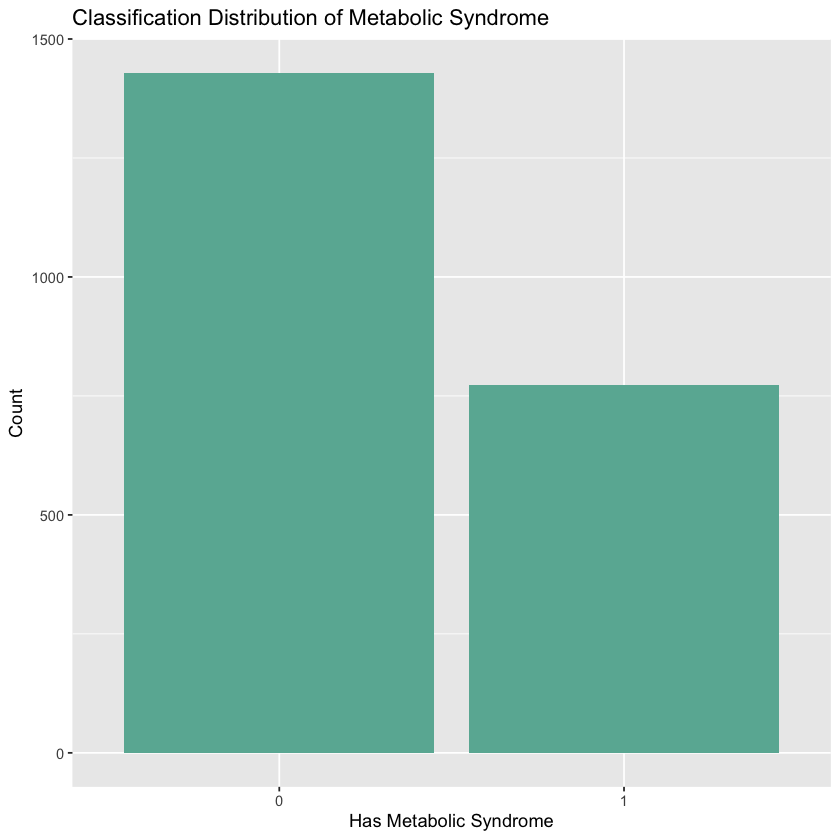

In [7]:
#Exploratory Data Analysis:

# Class distribution
table(met_data_clean$MetabolicSyndrome)

# Plot class balance
ggplot(met_data_clean, aes(x = MetabolicSyndrome)) +
  geom_bar(fill = "#69b3a2") +
  labs(title = "Classification Distribution of Metabolic Syndrome", x = "Has Metabolic Syndrome", y = "Count")

In [8]:
# See structure of key columns
str(met_data_clean[, c("BMI", "Age", "BloodGlucose", "HDL", "Triglycerides", "WaistCirc")])

# Print out any entries that fail to coerce to numeric
for (col in c("BMI", "Age", "BloodGlucose", "HDL", "Triglycerides", "WaistCirc")) {
  bad_vals <- met_data_clean[[col]][is.na(suppressWarnings(as.numeric(met_data_clean[[col]])))]
  if (length(bad_vals)) {
    cat("Non-numeric in", col, ":\n")
    print(unique(bad_vals))
  } else {
    cat("All values in", col, "are numeric.\n")
  }
}

'data.frame':	2201 obs. of  6 variables:
 $ BMI          : num  23.3 23.2 20.1 33.3 28.5 22.1 22.4 28.2 28 24.7 ...
 $ Age          : int  22 44 21 43 80 26 30 35 57 36 ...
 $ BloodGlucose : int  92 82 107 104 105 87 83 94 100 94 ...
 $ HDL          : int  41 28 43 73 47 61 48 46 35 58 ...
 $ Triglycerides: int  84 56 78 141 100 40 91 86 98 182 ...
 $ WaistCirc    : num  81 80.1 69.6 120.4 112.5 ...
All values in BMI are numeric.
All values in Age are numeric.
All values in BloodGlucose are numeric.
All values in HDL are numeric.
All values in Triglycerides are numeric.
All values in WaistCirc are numeric.


In [9]:
colnames(met_data_clean)

[1] "seqn"              "Age"               "Sex"              
 [4] "Marital"           "Income"            "Race"             
 [7] "WaistCirc"         "BMI"               "Albuminuria"      
[10] "UrAlbCr"           "UricAcid"          "BloodGlucose"     
[13] "HDL"               "Triglycerides"     "MetabolicSyndrome"

In [10]:
# Count how many 0’s and 1’s remain
table(met_data_clean$MetabolicSyndrome)


   0    1 
1429  772 

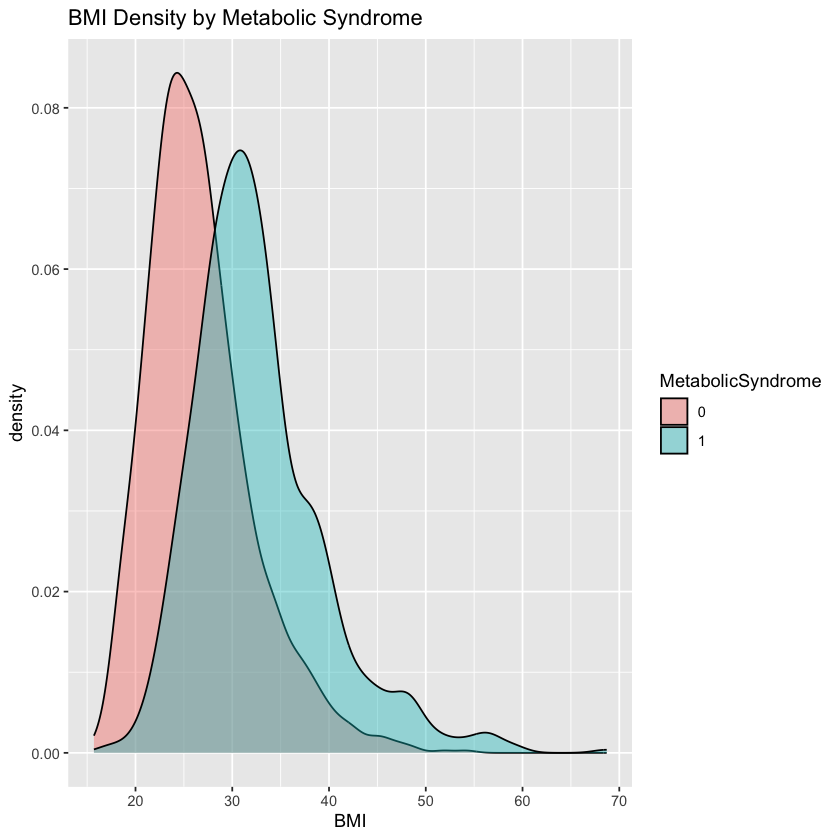

In [11]:
#Density Plots to show relationship with Metabolic Syndrome

#For BMI:
library(ggplot2)

ggplot(met_data_clean, aes(x = BMI, fill = MetabolicSyndrome)) +
  geom_density(alpha = 0.4) +
  labs(title = "BMI Density by Metabolic Syndrome")

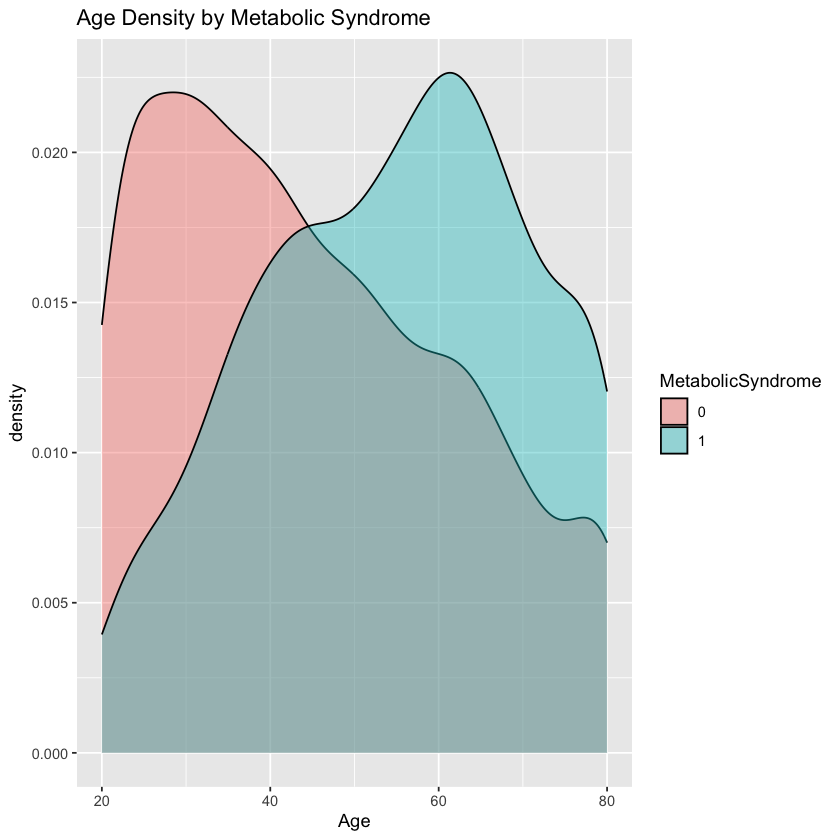

In [12]:
# For Age
ggplot(met_data_clean, aes(x = Age, fill = MetabolicSyndrome)) +
  geom_density(alpha = 0.4) +
  labs(title = "Age Density by Metabolic Syndrome")

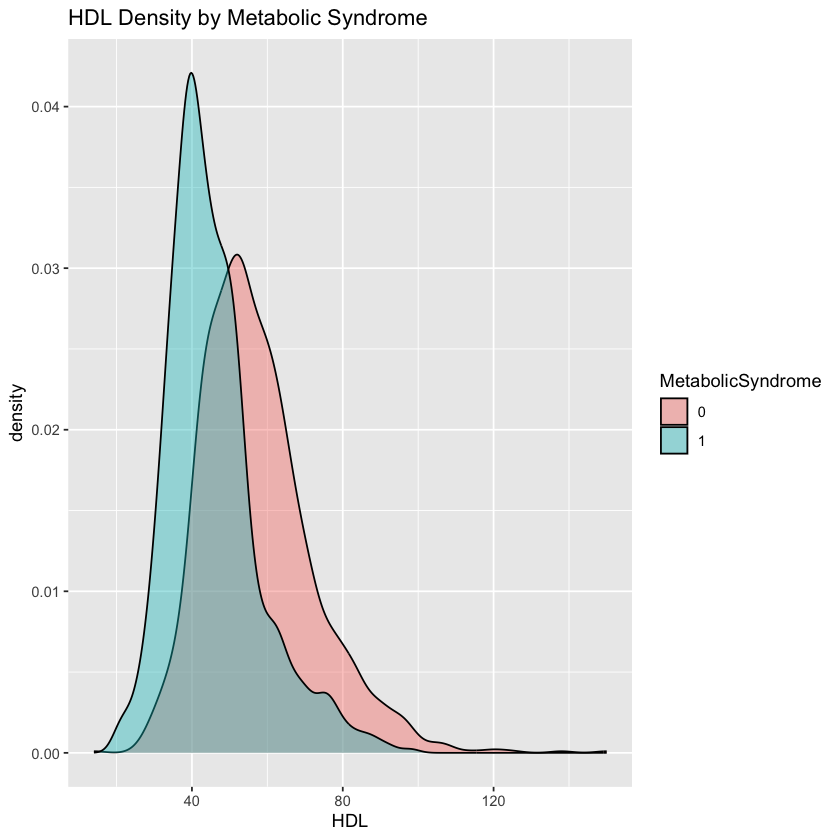

In [13]:
# For HDL
ggplot(met_data_clean, aes(x = HDL, fill = MetabolicSyndrome)) +
  geom_density(alpha = 0.4) +
  labs(title = "HDL Density by Metabolic Syndrome")

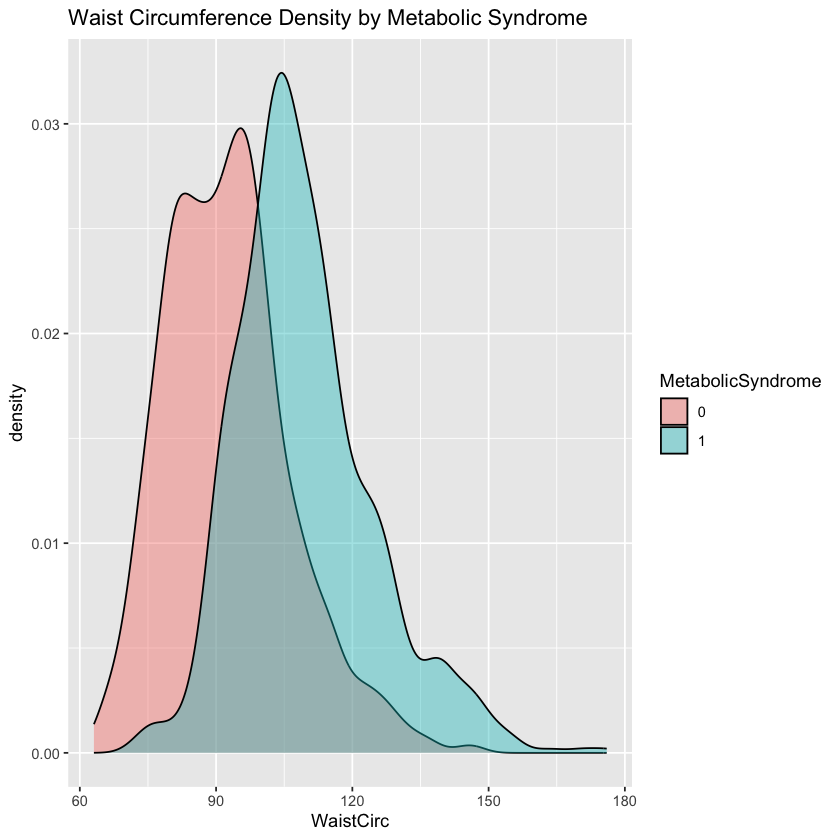

In [14]:
# For Waist Circumfrence
ggplot(met_data_clean, aes(x = WaistCirc, fill = MetabolicSyndrome)) +
  geom_density(alpha = 0.4) +
  labs(title = "Waist Circumference Density by Metabolic Syndrome")

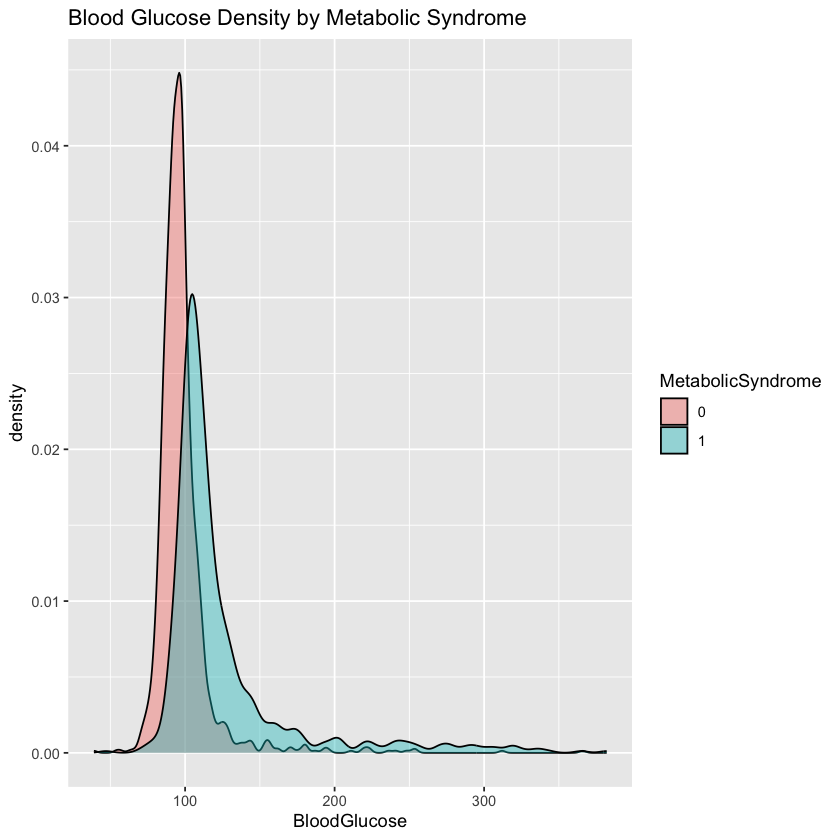

In [15]:
# For Blood Glucose
ggplot(met_data_clean, aes(x = BloodGlucose, fill = MetabolicSyndrome)) +
  geom_density(alpha = 0.4) +
  labs(title = "Blood Glucose Density by Metabolic Syndrome")

In [16]:
summary(met_data_clean$BloodGlucose)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   39.0    92.0    99.0   107.8   110.0   382.0 

In [17]:
#Observation: Very right-skewed for both classes. Those with MetS (class 1) show a strong right tail, suggesting elevated glucose levels.

#To reduce skew and improve model behavior, a log transformation was applied to create a new variable, LogBloodGlucose

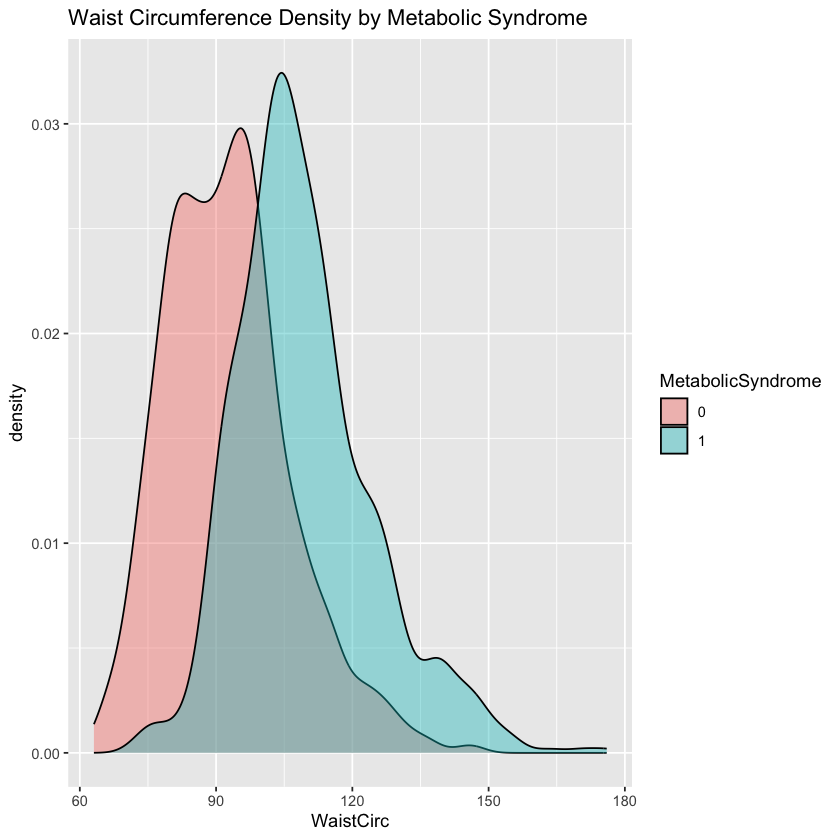

In [18]:
# For Waist Circumference
ggplot(met_data_clean, aes(x = WaistCirc, fill = MetabolicSyndrome)) +
  geom_density(alpha = 0.4) +
  labs(title = "Waist Circumference Density by Metabolic Syndrome")

In [19]:
met_data_clean <- met_data_clean %>%
  mutate(LogBloodGlucose = log(BloodGlucose))

In [20]:
summary(met_data_clean$LogBloodGlucose)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  3.664   4.522   4.595   4.648   4.700   5.945 

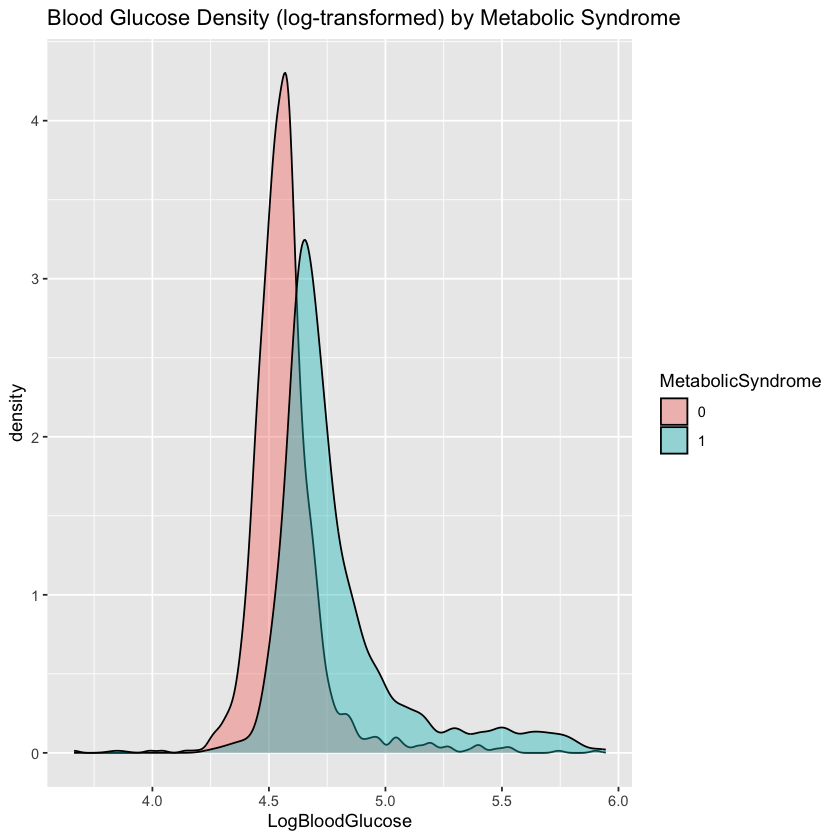

In [21]:
#Rerun improved desnity plot for Blood Glucose

ggplot(met_data_clean, aes(x = LogBloodGlucose, fill = MetabolicSyndrome)) +
  geom_density(alpha = 0.4) +
  labs(title = "Blood Glucose Density (log-transformed) by Metabolic Syndrome")

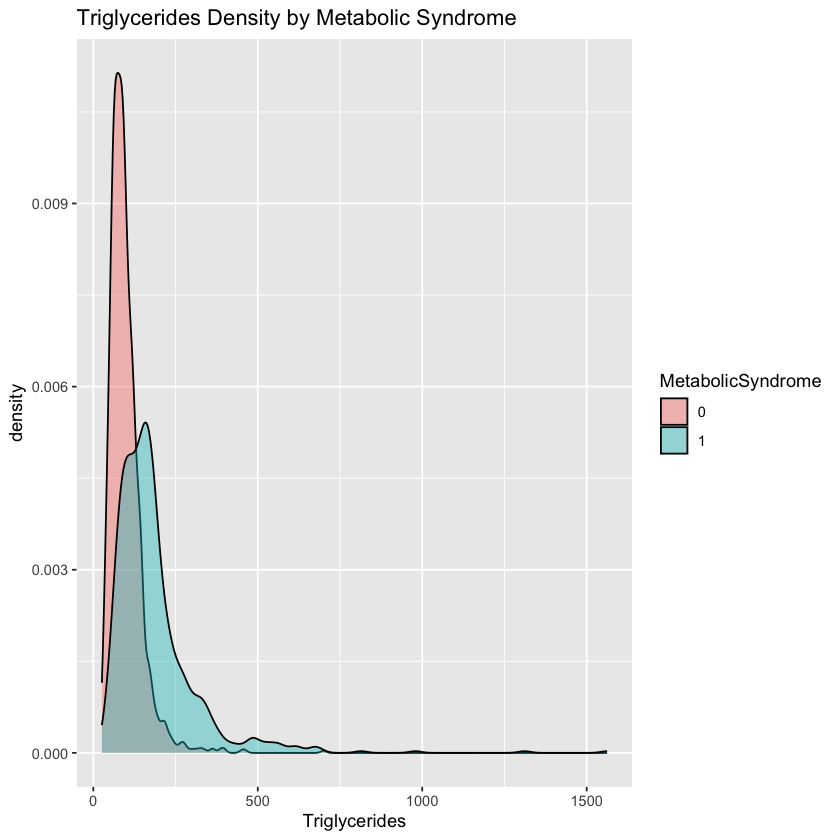

In [22]:
# For Triglycerides
ggplot(met_data_clean, aes(x = Triglycerides, fill = MetabolicSyndrome)) +
  geom_density(alpha = 0.4) +
  labs(title = "Triglycerides Density by Metabolic Syndrome")

In [23]:
summary(met_data_clean$Triglycerides)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   26.0    75.0   103.0   128.2   150.0  1562.0 

In [24]:
summary(met_data_clean$Triglycerides)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   26.0    75.0   103.0   128.2   150.0  1562.0 

In [25]:
#Triglyceride levels in the dataset were highly skewed, with extreme outliers present (median ≈ 103, max ≈ 1562). 
#To reduce the impact of outliers and normalize the distribution, a log transformation was applied to create a new variable, 
# LogTriglycerides, which was used for EDA and modeling purposes.

In [26]:
met_data_clean <- met_data_clean %>%
  mutate(LogTriglycerides = log(Triglycerides))

In [27]:
summary(met_data_clean$LogTriglycerides)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  3.258   4.317   4.635   4.683   5.011   7.354 

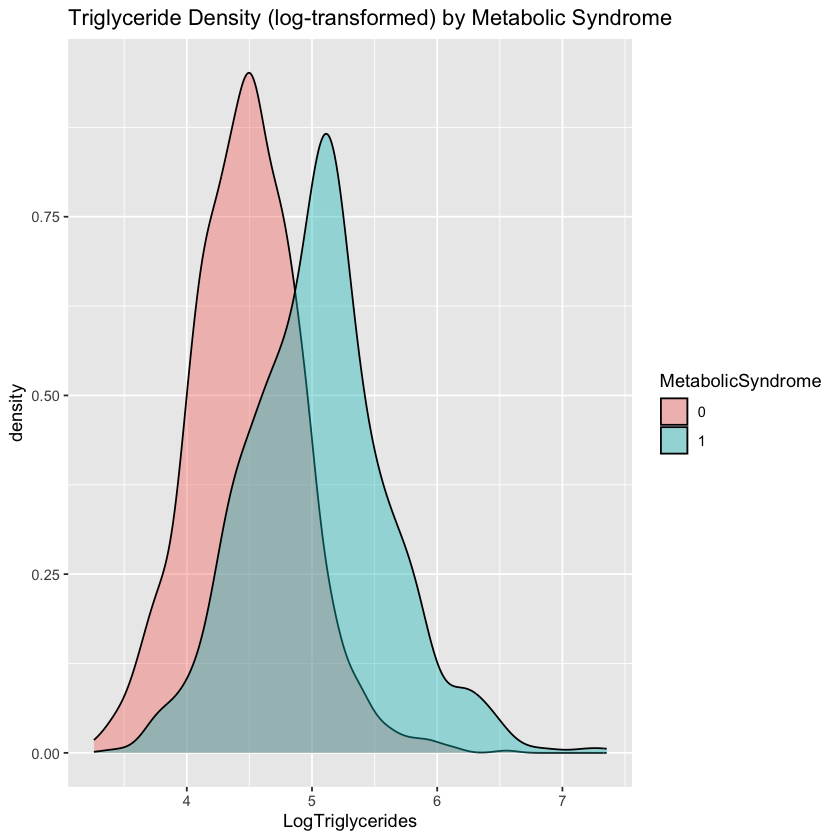

In [28]:
#Rerun improved density plot for Triglycerides

ggplot(met_data_clean, aes(x = LogTriglycerides, fill = MetabolicSyndrome)) +
  geom_density(alpha = 0.4) +
  labs(title = "Triglyceride Density (log-transformed) by Metabolic Syndrome")

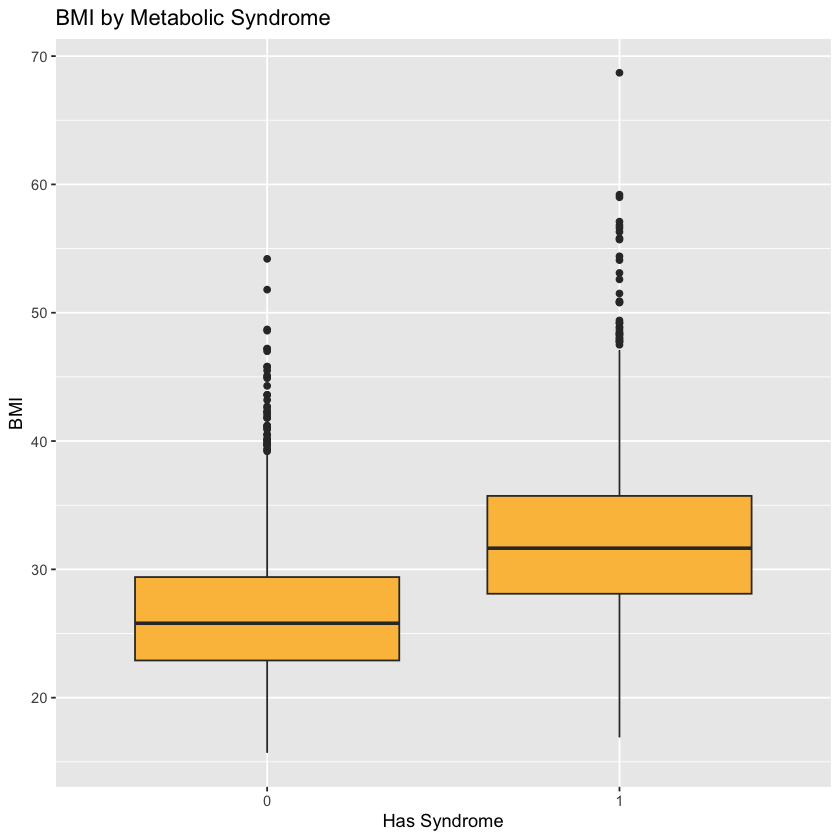

In [29]:
#Boxplots to show median, IQR, and outliers between classes:

#For BMI

ggplot(met_data_clean, aes(x = MetabolicSyndrome, y = BMI)) +
  geom_boxplot(fill = "#fcbf49") +
  labs(title = "BMI by Metabolic Syndrome", x = "Has Syndrome", y = "BMI")

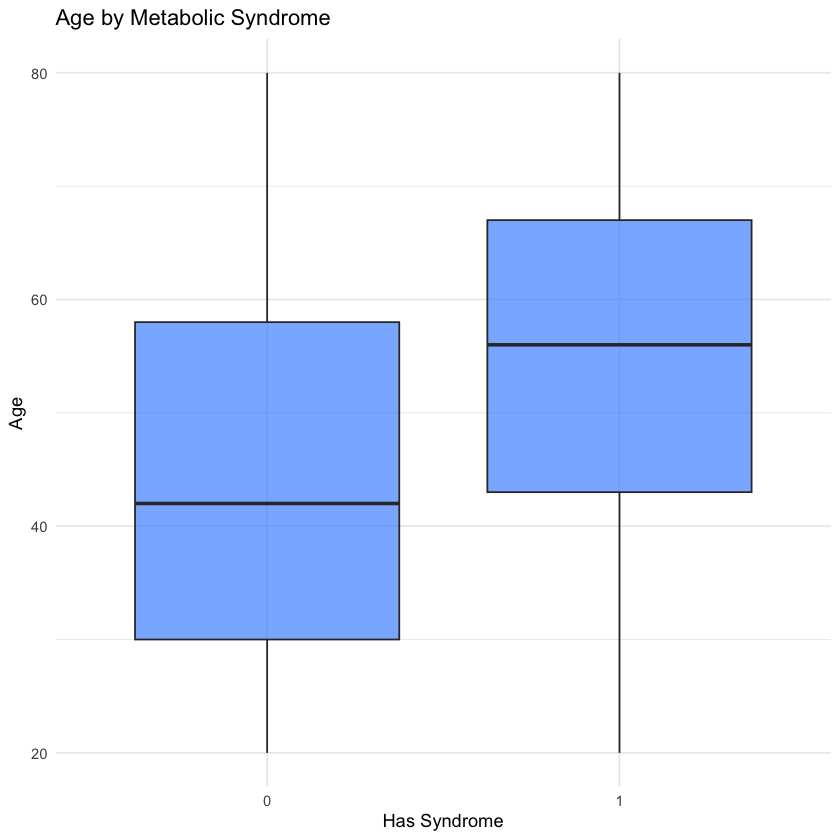

In [30]:
#For Age

ggplot(met_data_clean, aes(x = MetabolicSyndrome, y = Age)) +
  geom_boxplot(fill = "#4D96FF", alpha = 0.7) +
  labs(title = "Age by Metabolic Syndrome", x = "Has Syndrome", y = "Age") +
  theme_minimal()

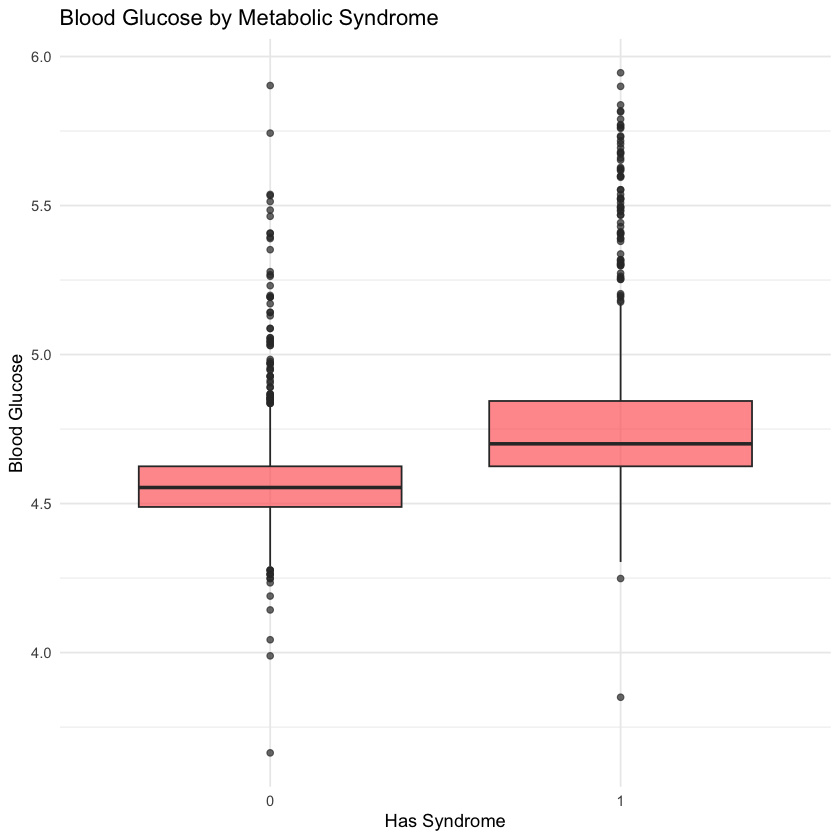

In [31]:
#For (Log)Blood Glucose

ggplot(met_data_clean, aes(x = MetabolicSyndrome, y = LogBloodGlucose)) +
  geom_boxplot(fill = "#FF6B6B", alpha = 0.7) +
  labs(title = "Blood Glucose by Metabolic Syndrome", x = "Has Syndrome", y = "Blood Glucose") +
  theme_minimal()

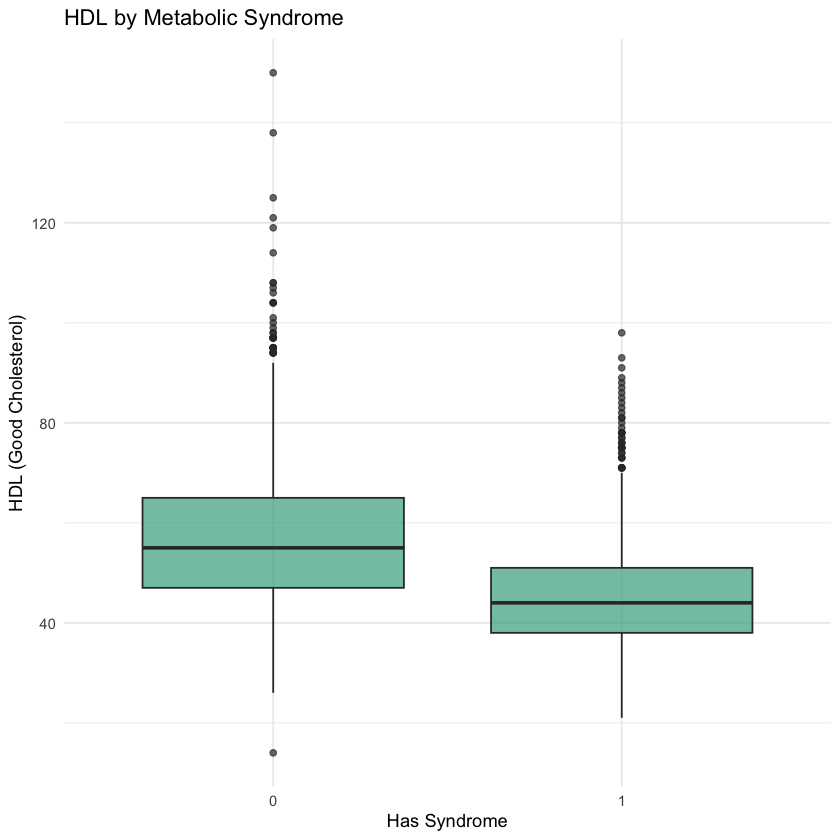

In [32]:
#For HDL (good cholesterol)

ggplot(met_data_clean, aes(x = MetabolicSyndrome, y = HDL)) +
  geom_boxplot(fill = "#43AA8B", alpha = 0.7) +
  labs(title = "HDL by Metabolic Syndrome", x = "Has Syndrome", y = "HDL (Good Cholesterol)") +
  theme_minimal()

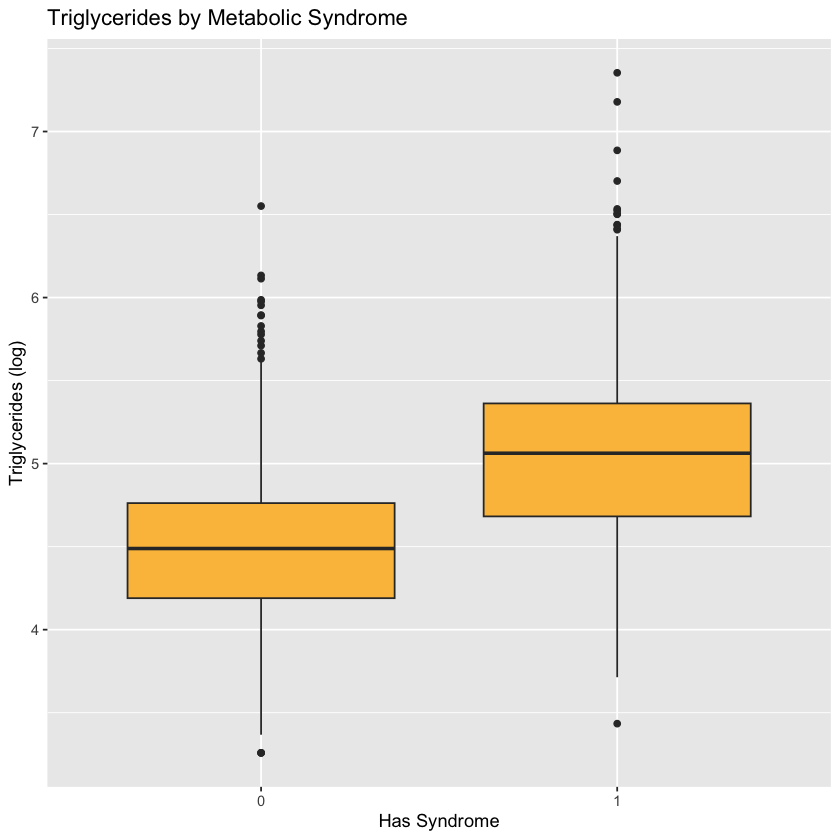

In [33]:
# For log(Triglycerides)
ggplot(met_data_clean, aes(x = MetabolicSyndrome, y = LogTriglycerides)) +
  geom_boxplot(fill = "#fcbf49") +
  labs(
    title = "Triglycerides by Metabolic Syndrome",
    x = "Has Syndrome",
    y = "Triglycerides (log)"
  )

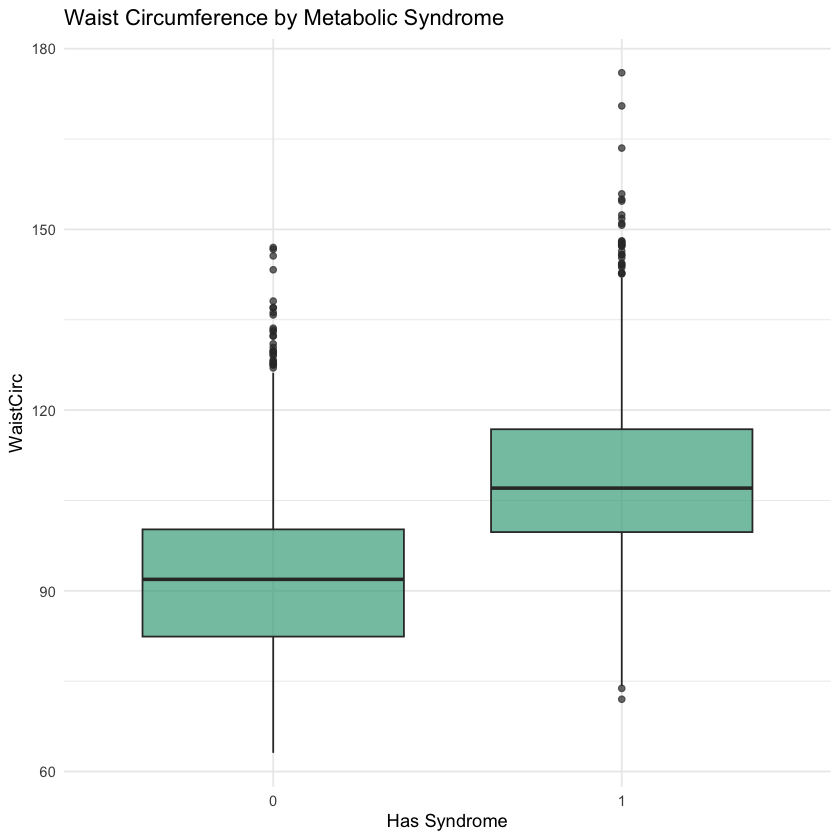

In [34]:
#For Waist Circumference

ggplot(met_data_clean, aes(x = MetabolicSyndrome, y = WaistCirc)) +
  geom_boxplot(fill = "#43AA8B", alpha = 0.7) +
  labs(title = "Waist Circumference by Metabolic Syndrome", x = "Has Syndrome", y = "WaistCirc") +
  theme_minimal()

In [35]:
library(ggplot2)

# p1: BMI
p1 <- ggplot(met_data_clean, aes(x = MetabolicSyndrome, y = BMI)) +
  geom_boxplot(fill = "#fcbf49") +
  labs(title = "BMI\nby Metabolic Syndrome", x = "Has Syndrome", y = "BMI") +
  theme_minimal()

# p2: Age
p2 <- ggplot(met_data_clean, aes(x = MetabolicSyndrome, y = Age)) +
  geom_boxplot(fill = "#4dabf7") +
  labs(title = "Ag\nby Metabolic Syndrome", x = "Has Syndrome", y = "Age") +
  theme_minimal()

# p3: Blood Glucose
p3 <- ggplot(met_data_clean, aes(x = MetabolicSyndrome, y = LogBloodGlucose)) +
  geom_boxplot(fill = "#ff6b6b") +
  labs(title = "Blood Glucose(log)\nby Metabolic Syndrome", x = "Has Syndrome", y = "Log(Blood Glucose)") +
  theme_minimal()

# p4: HDL
p4 <- ggplot(met_data_clean, aes(x = MetabolicSyndrome, y = HDL)) +
  geom_boxplot(fill = "#69db7c") +
  labs(title = "HDL\nby Metabolic Syndrome", x = "Has Syndrome", y = "HDL") +
  theme_minimal()

# p5: Waist Circumference
p5 <- ggplot(met_data_clean, aes(x = MetabolicSyndrome, y = WaistCirc)) +
  geom_boxplot(fill = "#74c0fc") +
  labs(title = "Waist Circumference\nby Metabolic Syndrome", x = "Has Syndrome", y = "WaistCirc") +
  theme_minimal()

# p6: Triglycerides (log)
p6 <- ggplot(met_data_clean, aes(x = MetabolicSyndrome, y = LogTriglycerides)) +
  geom_boxplot(fill = "#ffd43b") +
  labs(title = "Triglycerides (log)\nby Metabolic Syndrome", x = "Has Syndrome", y = "Triglycerides (log)") +
  theme_minimal()

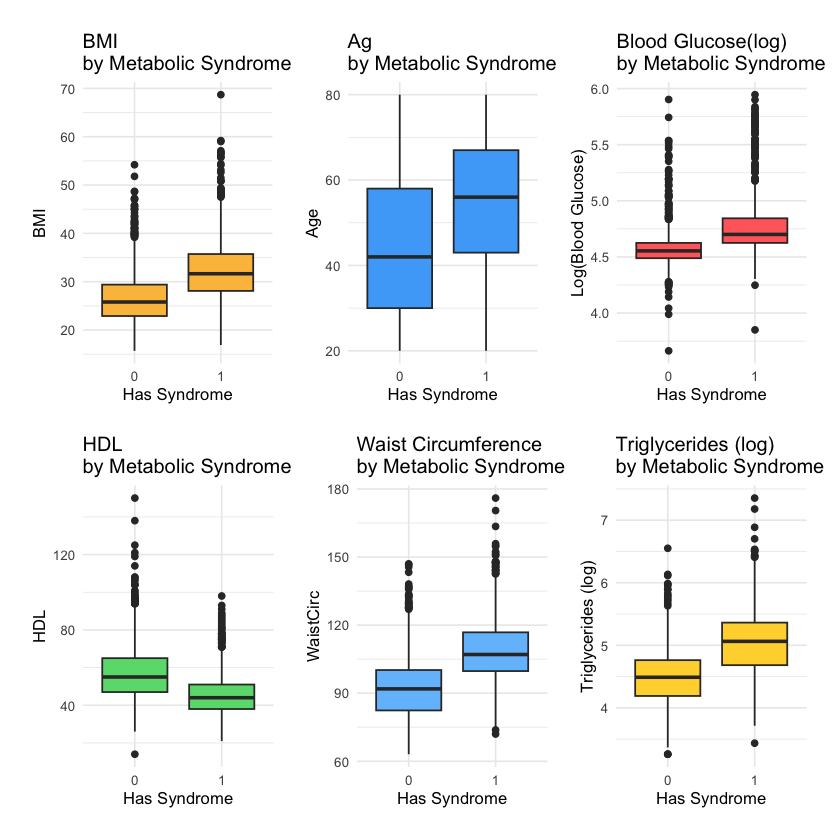

In [36]:
# 3 columns x 2 rows grid of all box plots
combined_plot <- (p1 | p2 | p3) / 
                 (p4 | p5 | p6) +
                 plot_layout(guides = "collect") &
                 theme_minimal(base_size = 10) &
                 ggplot2::theme(plot.margin = grid::unit(c(10, 10, 10, 10), "pt"))
combined_plot

In [37]:
ggsave("combined_boxplots_3x2.png", combined_plot, width = 14, height = 8, dpi = 300)

In [38]:
#Train/Test split data

# Set seed for reproducibility
set.seed(123)

# Create stratified train/test split (80/20)
split_index <- createDataPartition(met_data_clean$MetabolicSyndrome, p = 0.8, list = FALSE)

# Split into train and test
train_data <- met_data_clean[split_index, ]
test_data  <- met_data_clean[-split_index, ]

# Check class distribution in both sets
prop.table(table(train_data$MetabolicSyndrome))
prop.table(table(test_data$MetabolicSyndrome))


        0         1 
0.6492622 0.3507378 


        0         1 
0.6492027 0.3507973 

In [39]:
#Model building

#1: Logistic Regression Model

# Build logistic regression model on training data
logit_model <- glm(MetabolicSyndrome ~ BMI + Age + LogBloodGlucose + HDL + 
                   WaistCirc + LogTriglycerides, 
                   data = train_data, family = binomial)


# Model summary
summary(logit_model)


Call:
glm(formula = MetabolicSyndrome ~ BMI + Age + LogBloodGlucose + 
    HDL + WaistCirc + LogTriglycerides, family = binomial, data = train_data)

Coefficients:
                   Estimate Std. Error z value Pr(>|z|)    
(Intercept)      -38.415102   2.624706 -14.636  < 2e-16 ***
BMI                0.124029   0.027068   4.582 4.60e-06 ***
Age                0.037119   0.004932   7.526 5.24e-14 ***
LogBloodGlucose    4.585695   0.467964   9.799  < 2e-16 ***
HDL               -0.034567   0.006762  -5.112 3.19e-07 ***
WaistCirc          0.020902   0.011524   1.814   0.0697 .  
LogTriglycerides   2.218997   0.183475  12.094  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 2283.2  on 1761  degrees of freedom
Residual deviance: 1219.6  on 1755  degrees of freedom
AIC: 1233.6

Number of Fisher Scoring iterations: 6


Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0 248  37
         1  37 117
                                          
               Accuracy : 0.8314          
                 95% CI : (0.7931, 0.8653)
    No Information Rate : 0.6492          
    P-Value [Acc > NIR] : <2e-16          
                                          
                  Kappa : 0.6299          
                                          
 Mcnemar's Test P-Value : 1               
                                          
            Sensitivity : 0.7597          
            Specificity : 0.8702          
         Pos Pred Value : 0.7597          
         Neg Pred Value : 0.8702          
             Prevalence : 0.3508          
         Detection Rate : 0.2665          
   Detection Prevalence : 0.3508          
      Balanced Accuracy : 0.8150          
                                          
       'Positive' Class : 1               
                              

Setting levels: control = 0, case = 1

Setting direction: controls < cases



Area under the curve: 0.9056


Cohen’s Kappa: 0.6299157 
95% CI for Accuracy: 0.793 0.865 


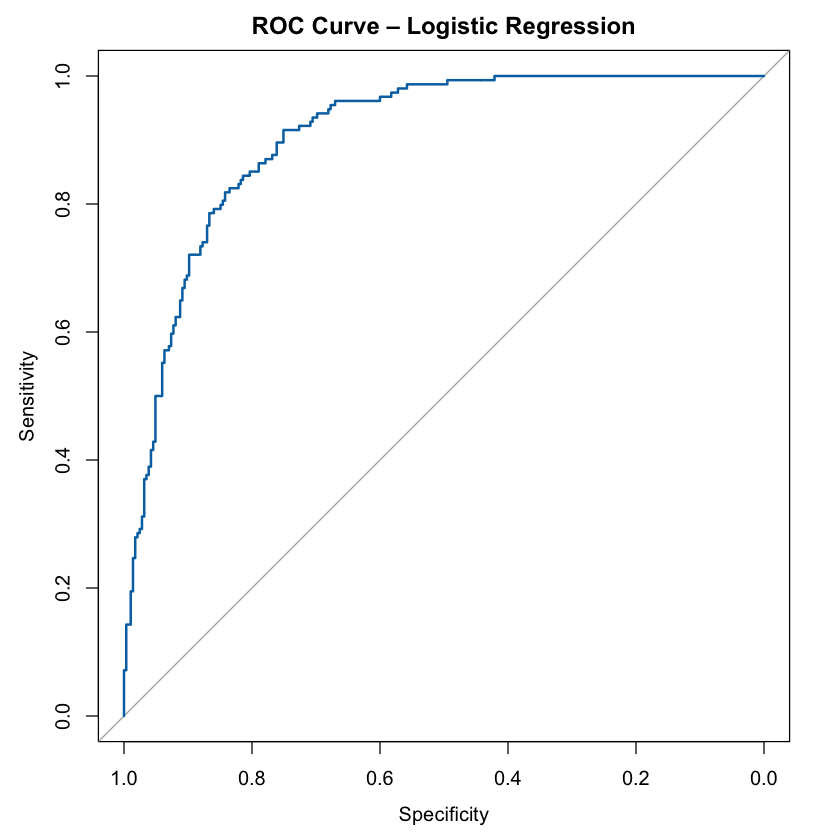

In [40]:
#Evaluate the Logistic Regression Model

# Predict probabilities
logit_probs <- predict(logit_model, newdata = test_data, type = "response")

# Convert to class (threshold = 0.5)
logit_preds <- ifelse(logit_probs > 0.5, 1, 0)

# Convert to factors
logit_preds <- factor(logit_preds, levels = c(0, 1))
true_labels <- factor(test_data$MetabolicSyndrome, levels = c(0, 1))

# Confusion matrix
conf_mat <- confusionMatrix(logit_preds, true_labels, positive = "1")
print(conf_mat)

# ROC Curve & AUC
roc_logit <- roc(true_labels, logit_probs)
plot(roc_logit, col = "#0072B2", lwd = 2, main = "ROC Curve – Logistic Regression")
auc(roc_logit)

# Cohen's Kappa
kappa_val <- conf_mat$overall["Kappa"]
cat("\nCohen’s Kappa:", kappa_val, "\n")

# 95% CI for Accuracy
ci <- conf_mat$overall[c("AccuracyLower", "AccuracyUpper")]
cat("95% CI for Accuracy:", round(ci, 3), "\n")